<a href="https://colab.research.google.com/github/julidoominguez/SeriesdeTiempoAustral/blob/main/TP_series_temporales_facturacion_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.0 MB/s eta 0:00:00


In [ ]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np
from datetime import timedelta                                 # diferencia de dos fechas

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statsmodels.api as sm                                   # modelos estadísticos
# !pip install pmdarima
import pmdarima as pm                                          # modelado automático SARIMA
from statsmodels.tsa.arima_model import ARIMA                  # modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         # modelo SARIMAX
from pylab import rcParams                                     # descomposicion de series temporales
from statsmodels.tsa.stattools import adfuller, kpss           # test Dickey-Fuller y KPSS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
!pip install gspread
!pip install gspread-dataframe
!pip install --upgrade gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.0.2
    Uninstalling gspread-6.0.2:
      Successfully uninstalled gspread-6.0.2


In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1FSIizX5kpfBN14TNLekfFVNDO0dHJospR8aM0CNkQlg/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_ventas_vitalcer = pd.read_csv(csv_url)


print(df_ventas_vitalcer.head())



   Nro       Fecha       Hora         Comprobante               Descripción  \
0  165  15/11/2019   08:23 pm  FACTURA C-00000022  { CAE: 69465360611171} -   
1  164  15/11/2019   08:09 pm   REMITO X-00000140                       NaN   
2  163  15/11/2019   08:01 pm   REMITO X-00000139                       NaN   
3  162  15/11/2019   07:45 pm   REMITO X-00000138                       NaN   
4  161  15/11/2019   07:44 pm  FACTURA C-00000021  { CAE: 69465358657978} -   

            Cliente       Monto  
0  Consumidor Final  $ 1.164,60  
1  Consumidor Final    $ 705,83  
2  Consumidor Final    $ 320,00  
3  Consumidor Final    $ 125,00  
4  Consumidor Final    $ 260,00  


In [ ]:
# Convertir la columna Monto a tipo numérico
df_ventas_vitalcer['Monto'] = df_ventas_vitalcer['Monto'].str.replace('$', '', regex=False)  # Eliminar símbolo de moneda
df_ventas_vitalcer['Monto'] = df_ventas_vitalcer['Monto'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)  # Reemplazar comas y puntos
df_ventas_vitalcer['Monto'] = df_ventas_vitalcer['Monto'].astype(float)  # Convertir a float

# Convertir la columna Fecha a tipo datetime
df_ventas_vitalcer['Fecha'] = pd.to_datetime(df_ventas_vitalcer['Fecha'], format='%d/%m/%Y')

# Mostrar las primeras filas del DataFrame para verificar las conversiones
print(df_ventas_vitalcer.head())

   Nro      Fecha       Hora         Comprobante               Descripción  \
0  165 2019-11-15   08:23 pm  FACTURA C-00000022  { CAE: 69465360611171} -   
1  164 2019-11-15   08:09 pm   REMITO X-00000140                       NaN   
2  163 2019-11-15   08:01 pm   REMITO X-00000139                       NaN   
3  162 2019-11-15   07:45 pm   REMITO X-00000138                       NaN   
4  161 2019-11-15   07:44 pm  FACTURA C-00000021  { CAE: 69465358657978} -   

            Cliente   Monto  
0  Consumidor Final 1164.60  
1  Consumidor Final  705.83  
2  Consumidor Final  320.00  
3  Consumidor Final  125.00  
4  Consumidor Final  260.00  


In [ ]:
df_ventas_vitalcer.Monto.describe()

count   122759.00
mean      1790.72
std       3332.23
min          0.00
25%        300.00
50%        720.00
75%       1800.00
max     198580.00
Name: Monto, dtype: float64

In [ ]:
# Agrupar por la columna 'Fecha' y sumar los valores de la columna 'Monto'
df_ventas_agregadas = df_ventas_vitalcer.groupby('Fecha')['Monto'].sum().reset_index()

# Mostrar las primeras filas del DataFrame resultante para verificar
print(df_ventas_agregadas.head())

       Fecha    Monto
0 2019-11-15 26796.40
1 2019-11-16 20712.54
2 2019-11-19 27271.31
3 2019-11-20 14520.83
4 2019-11-21 17245.30


In [ ]:
display(df_ventas_agregadas)

,Fecha,Monto
0,2019-11-15,26796.40
1,2019-11-16,20712.54
2,2019-11-19,27271.31
3,2019-11-20,14520.83
4,2019-11-21,17245.30
...,...,...
1375,2024-06-22,707310.00
1376,2024-06-24,758690.00
1377,2024-06-25,614865.00
1378,2024-06-26,765132.00


In [ ]:
# Buscamos datos de inflacion para deflactar la serie
import requests
import pandas as pd

url = "https://apis.datos.gob.ar/series/api/series/?ids=145.3_INGNACNAL_DICI_M_15&format=json"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    # Extraer la parte de los datos que contiene las series temporales
    if 'data' in data:
        # Convertir los datos a DataFrame
        ipc = pd.DataFrame(data['data'], columns=['timestamp', 'value'])
        ipc['timestamp'] = pd.to_datetime(ipc['timestamp'])  # Convertir timestamp a formato datetime de pandas
        print("Número total de entradas:", ipc.shape[0])  # Muestra el total de filas
        print(ipc.head(10))  # Imprimir las primeras 10 filas para verificar
        print(ipc.tail(10))  # Imprimir las últimas 10 filas para verificar
    else:
        print("No se encontraron datos de series temporales.")
else:
    print("Error al obtener los datos. Código de estado:", response.status_code)

# Convertir timestamp a datetime si aún no está convertido
ipc['timestamp'] = pd.to_datetime(ipc['timestamp'])

# Calcular el cambio porcentual mensual
ipc['variacion_mes'] = ipc['value'].pct_change() * 100

print(ipc.head())


Número total de entradas: 90
   timestamp  value
0 2016-12-01 100.00
1 2017-01-01 101.59
2 2017-02-01 103.69
3 2017-03-01 106.15
4 2017-04-01 108.97
5 2017-05-01 110.53
6 2017-06-01 111.85
7 2017-07-01 113.79
8 2017-08-01 115.38
9 2017-09-01 117.57
    timestamp   value
80 2023-08-01 2044.28
81 2023-09-01 2304.92
82 2023-10-01 2496.27
83 2023-11-01 2816.06
84 2023-12-01 3533.19
85 2024-01-01 4261.53
86 2024-02-01 4825.79
87 2024-03-01 5357.09
88 2024-04-01 5830.23
89 2024-05-01 6073.70
   timestamp  value  variacion_mes
0 2016-12-01 100.00            NaN
1 2017-01-01 101.59           1.59
2 2017-02-01 103.69           2.07
3 2017-03-01 106.15           2.37
4 2017-04-01 108.97           2.66


In [ ]:
display(ipc)

,timestamp,value,variacion_mes
0,2016-12-01,100.00,NaN
1,2017-01-01,101.59,1.59
2,2017-02-01,103.69,2.07
3,2017-03-01,106.15,2.37
4,2017-04-01,108.97,2.66
...,...,...,...
85,2024-01-01,4261.53,20.61
86,2024-02-01,4825.79,13.24
87,2024-03-01,5357.09,11.01
88,2024-04-01,5830.23,8.83


In [ ]:
# Crear un rango de fechas desde el inicio hasta el final del periodo de ventas
rango_fechas = pd.date_range(start=ipc['timestamp'].min(), end=df_ventas_vitalcer['Fecha'].max(), freq='D')

# Reindexar el DataFrame ipc para incluir todas las fechas en el rango, usando el valor más cercano (ffill)
ipc_diario = ipc.set_index('timestamp').reindex(rango_fechas).ffill().reset_index()
ipc_diario.columns = ['Fecha', 'value', 'variacion_mes']

# Verificar el DataFrame resultante
print(ipc_diario.head(20))
print(ipc_diario.tail(20))

        Fecha  value  variacion_mes
0  2016-12-01 100.00            NaN
1  2016-12-02 100.00            NaN
2  2016-12-03 100.00            NaN
3  2016-12-04 100.00            NaN
4  2016-12-05 100.00            NaN
5  2016-12-06 100.00            NaN
6  2016-12-07 100.00            NaN
7  2016-12-08 100.00            NaN
8  2016-12-09 100.00            NaN
9  2016-12-10 100.00            NaN
10 2016-12-11 100.00            NaN
11 2016-12-12 100.00            NaN
12 2016-12-13 100.00            NaN
13 2016-12-14 100.00            NaN
14 2016-12-15 100.00            NaN
15 2016-12-16 100.00            NaN
16 2016-12-17 100.00            NaN
17 2016-12-18 100.00            NaN
18 2016-12-19 100.00            NaN
19 2016-12-20 100.00            NaN
          Fecha   value  variacion_mes
2746 2024-06-08 6073.70           4.18
2747 2024-06-09 6073.70           4.18
2748 2024-06-10 6073.70           4.18
2749 2024-06-11 6073.70           4.18
2750 2024-06-12 6073.70           4.18
2751 2024-

In [ ]:
display(ipc_diario)

,Fecha,value,variacion_mes
0,2016-12-01,100.00,NaN
1,2016-12-02,100.00,NaN
2,2016-12-03,100.00,NaN
3,2016-12-04,100.00,NaN
4,2016-12-05,100.00,NaN
...,...,...,...
2761,2024-06-23,6073.70,4.18
2762,2024-06-24,6073.70,4.18
2763,2024-06-25,6073.70,4.18
2764,2024-06-26,6073.70,4.18


In [ ]:
# Crear un nuevo DataFrame para los datos deflactados
df_ventas_deflactadas = df_ventas_agregadas.copy()

# Unir los datos de ventas con los datos del IPC diario interpolados
df_ventas_deflactadas = pd.merge(df_ventas_deflactadas, ipc_diario[['Fecha', 'value']], on='Fecha', how='left')
df_ventas_deflactadas.rename(columns={'value': 'ipc'}, inplace=True)

# Calcular el índice de precios relativo al último índice disponible (para deflactar)
ultimo_ipc = ipc['value'].iloc[-1]
df_ventas_deflactadas['ipc_relativo'] = df_ventas_deflactadas['ipc'] / ultimo_ipc

# Deflactar el monto
df_ventas_deflactadas['Monto_deflactado'] = df_ventas_deflactadas['Monto'] / df_ventas_deflactadas['ipc_relativo']

# Mostrar las primeras filas del DataFrame resultante para verificar
print(df_ventas_deflactadas.head())

       Fecha    Monto    ipc  ipc_relativo  Monto_deflactado
0 2019-11-15 26796.40 273.22          0.04         595695.03
1 2019-11-16 20712.54 273.22          0.04         460448.31
2 2019-11-19 27271.31 273.22          0.04         606252.48
3 2019-11-20 14520.83 273.22          0.04         322804.04
4 2019-11-21 17245.30 273.22          0.04         383370.14


In [ ]:
display(df_ventas_deflactadas)

,Fecha,Monto,ipc,ipc_relativo,Monto_deflactado
0,2019-11-15,26796.40,273.2158,0.044983,595695.031839
1,2019-11-16,20712.54,273.2158,0.044983,460448.313011
2,2019-11-19,27271.31,273.2158,0.044983,606252.477152
3,2019-11-20,14520.83,273.2158,0.044983,322804.044169
4,2019-11-21,17245.30,273.2158,0.044983,383370.136756
...,...,...,...,...,...
1375,2024-06-22,707310.00,6073.7000,1.000000,707310.000000
1376,2024-06-24,758690.00,6073.7000,1.000000,758690.000000
1377,2024-06-25,614865.00,6073.7000,1.000000,614865.000000
1378,2024-06-26,765132.00,6073.7000,1.000000,765132.000000


In [ ]:
df_ventas_deflactadas.Monto_deflactado.describe()

count      1380.00
mean     687485.26
std      168212.79
min       25758.24
25%      576935.21
50%      677943.15
75%      794300.46
max     1396256.76
Name: Monto_deflactado, dtype: float64

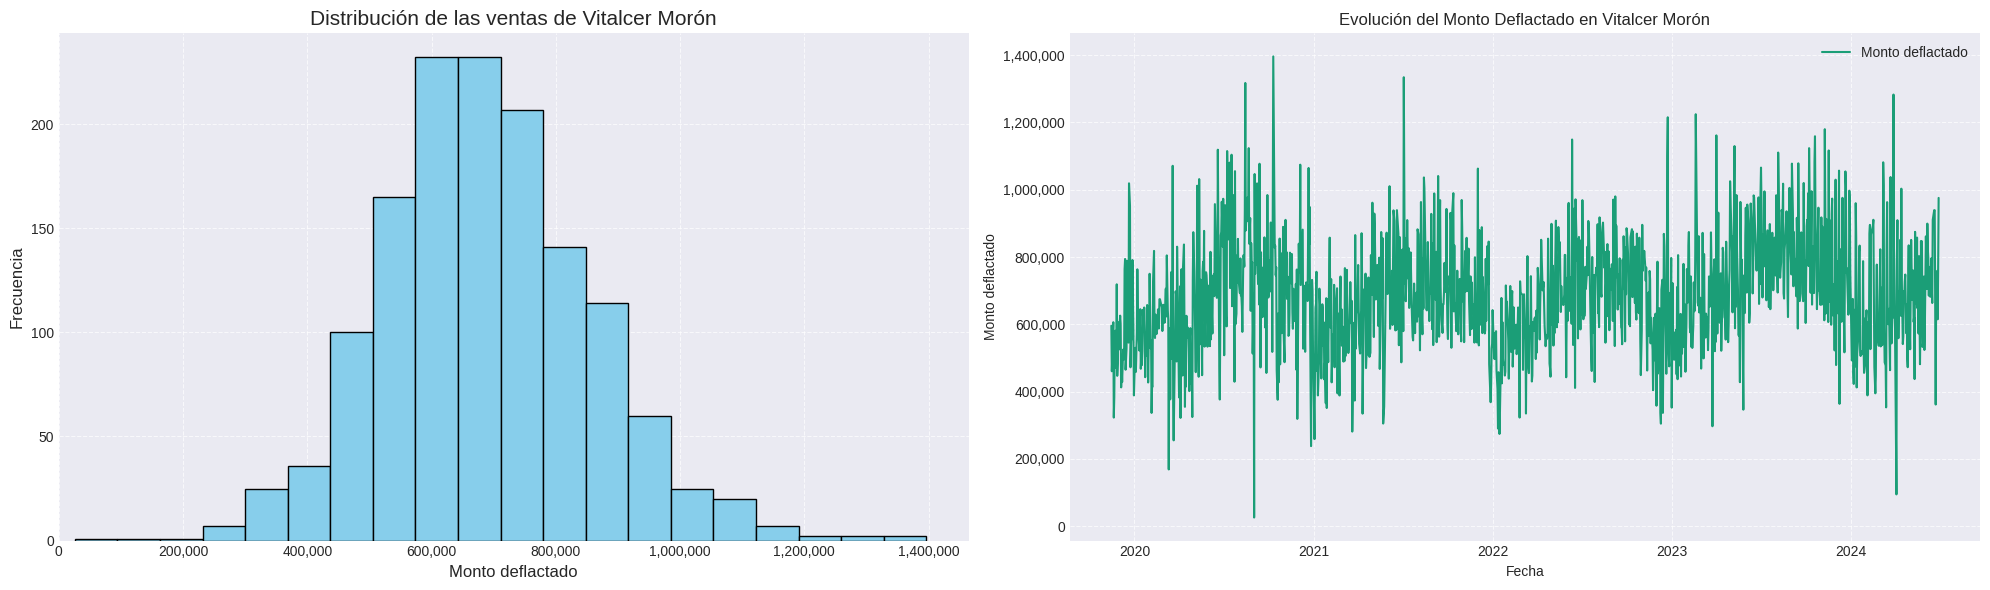

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Función para formatear los valores del eje
def format_func(value, tick_number):
    return f'{value:,.0f}'

# Función para graficar la serie
def _plot_series(series, series_name, series_index=0):
    palette = list(sns.color_palette('Dark2'))
    xs = series['Fecha']
    ys = series['Monto_deflactado']
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Establecer estilo de gráfico
plt.style.use('seaborn-darkgrid')

# Crear la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Gráfico 1: Histograma
df_ventas_deflactadas['Monto_deflactado'].plot(kind='hist', bins=20, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribución de las ventas de Vitalcer Morón', fontsize=15)
ax1.set_xlabel('Monto deflactado', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlim(left=0)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
ax1.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: Serie temporal
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)
_plot_series(df_sorted, 'Monto deflactado')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Monto deflactado')
ax2.set_title('Evolución del Monto Deflactado en Vitalcer Morón')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.yaxis.set_major_formatter(FuncFormatter(format_func))
sns.despine(ax=ax2)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

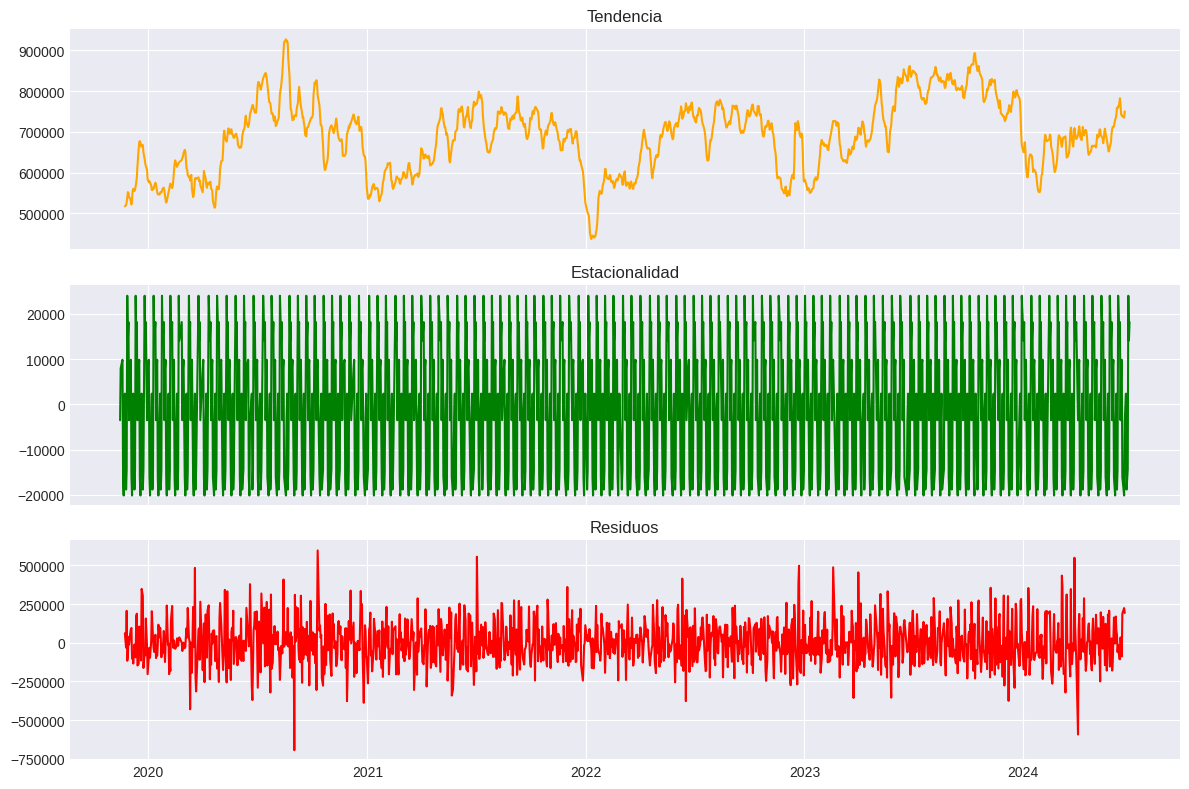

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizar la descomposición de la serie temporal
decomposition = seasonal_decompose(df_sorted['Monto_deflactado'], model='additive', period=12)

# Graficar los componentes de la descomposición
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Tendencia
axs[0].plot(df_sorted['Fecha'], decomposition.trend, color='orange')
axs[0].set_title('Tendencia')
axs[0].legend().set_visible(False)

# Estacionalidad
axs[1].plot(df_sorted['Fecha'], decomposition.seasonal, color='green')
axs[1].set_title('Estacionalidad')
axs[1].legend().set_visible(False)

# Ajustar límites del eje Y para mejorar la visualización
axs[1].set_ylim([decomposition.seasonal.min() * 1.1, decomposition.seasonal.max() * 1.1])

# Residuos
axs[2].plot(df_sorted['Fecha'], decomposition.resid, color='red')
axs[2].set_title('Residuos')
axs[2].legend().set_visible(False)

plt.tight_layout()
plt.show()


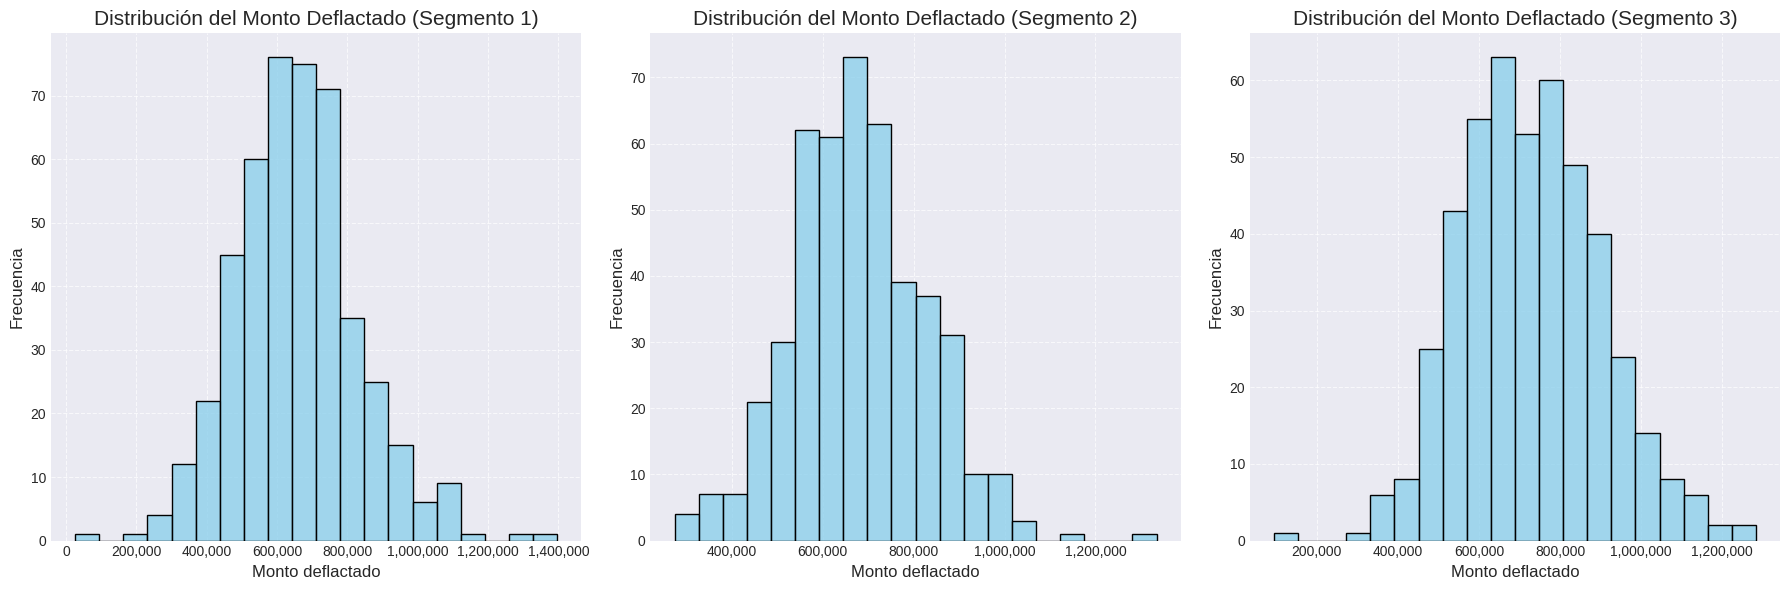

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Función para formatear los valores del eje X
def format_func(value, tick_number):
    return f'{value:,.0f}'

# Dividir el DataFrame en tres segmentos
n = len(df_sorted)
segment1 = df_sorted.iloc[:n//3]
segment2 = df_sorted.iloc[n//3:2*n//3]
segment3 = df_sorted.iloc[2*n//3:]

# Crear la figura y los ejes para los histogramas
fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout='constrained')

# Graficar los histogramas
sns.histplot(segment1['Monto_deflactado'], bins=20, ax=axs[0], color='skyblue', edgecolor='black')
sns.histplot(segment2['Monto_deflactado'], bins=20, ax=axs[1], color='skyblue', edgecolor='black')
sns.histplot(segment3['Monto_deflactado'], bins=20, ax=axs[2], color='skyblue', edgecolor='black')

# Añadir títulos y etiquetas
axs[0].set_title('Distribución del Monto Deflactado (Segmento 1)', fontsize=15)
axs[1].set_title('Distribución del Monto Deflactado (Segmento 2)', fontsize=15)
axs[2].set_title('Distribución del Monto Deflactado (Segmento 3)', fontsize=15)
for ax in axs:
    ax.set_xlabel('Monto deflactado', fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    sns.despine(ax=ax)
    ax.grid(True, linestyle='--', alpha=0.7)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

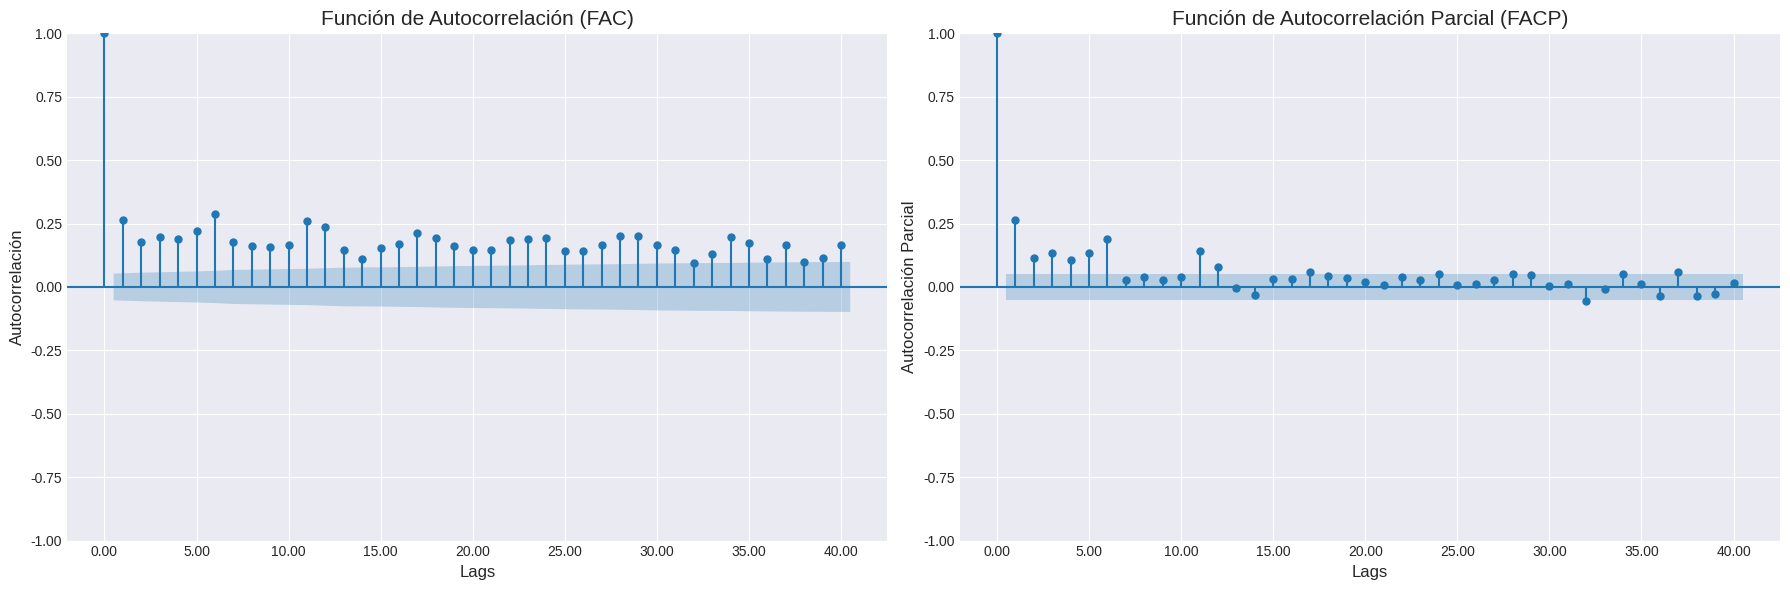

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import FuncFormatter

# Función para formatear los valores del eje Y
def format_func(value, tick_number):
    return f'{value:,.2f}'

# Ordenar el DataFrame por fecha
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)

# Crear la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(18, 6), layout='constrained')

# Graficar FAC
plot_acf(df_sorted['Monto_deflactado'], ax=axs[0], lags=40, alpha=0.05)
axs[0].set_title('Función de Autocorrelación (FAC)', fontsize=15)
axs[0].set_xlabel('Lags', fontsize=12)
axs[0].set_ylabel('Autocorrelación', fontsize=12)
axs[0].xaxis.set_major_formatter(FuncFormatter(format_func))
axs[0].yaxis.set_major_formatter(FuncFormatter(format_func))
axs[0].tick_params(axis='both', which='major', labelsize=10)
sns.despine(ax=axs[0])

# Graficar FACP
plot_pacf(df_sorted['Monto_deflactado'], ax=axs[1], lags=40, alpha=0.05)
axs[1].set_title('Función de Autocorrelación Parcial (FACP)', fontsize=15)
axs[1].set_xlabel('Lags', fontsize=12)
axs[1].set_ylabel('Autocorrelación Parcial', fontsize=12)
axs[1].xaxis.set_major_formatter(FuncFormatter(format_func))
axs[1].yaxis.set_major_formatter(FuncFormatter(format_func))
axs[1].tick_params(axis='both', which='major', labelsize=10)
sns.despine(ax=axs[1])

# Ajustar el layout
plt.tight_layout()
plt.show()

In [ ]:
!pip install arch
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

# Ordenar el DataFrame por fecha
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)

# Extract the series
series = df_sorted['Monto_deflactado']

# Prueba de Dickey-Fuller aumentada (ADF)
adf_result = adfuller(series)
print('Prueba ADF:')
print('Estadístico ADF:', adf_result[0])
print('Valor p:', adf_result[1])
print('Valores críticos:', adf_result[4])
print()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 13.5 MB/s eta 0:00:00
Prueba ADF:
Estadístico ADF: -4.293172025311778
Valor p: 0.00045646298593731273
Valores críticos: {'1%': -3.435163869552687, '5%': -2.863665960737661, '10%': -2.567901861810129}



In [ ]:
pp_result = PhillipsPerron(series)
print('Prueba PP:')
print('Estadístico PP:', pp_result.stat)
print('Valor p:', pp_result.pvalue)
print('Valores críticos:', pp_result.critical_values)
print()

Prueba PP:
Estadístico PP: -38.44835934567186
Valor p: 0.0
Valores críticos: {'1%': -3.4351009168670035, '5%': -2.863638180853028, '10%': -2.5678870681532424}



In [ ]:
# Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
kpss_result, p_value, lags, crit = kpss(series, regression='c')
print('Prueba KPSS:')
print('Estadístico KPSS:', kpss_result)
print('Valor p:', p_value)
print('Valores críticos:', crit)

Prueba KPSS:
Estadístico KPSS: 1.0497171557753415
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Paso 2: Ajuste del Mejor Modelo SARIMA:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Ordenar el DataFrame por fecha
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)

# Ajuste automático del modelo SARIMA con estacionalidad de 6 días (m=6)
sarima_model = auto_arima(df_sorted['Monto_deflactado'],
                          seasonal=True, m=6,
                          trace=True, error_action='ignore',
                          suppress_warnings=True)

# Resumen del mejor modelo encontrado
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=7.98 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=37637.922, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=37318.991, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=36881.523, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=37635.925, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=36892.305, Time=0.26 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=36882.293, Time=0.95 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=36879.742, Time=1.47 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=36881.458, Time=2.69 sec
 ARIMA(0,1,0)(0,0,2)[6] intercept   : AIC=37620.784, Time=0.59 sec
 ARIMA(1,1,1)(0,0,2)[6] intercept   : AIC=36874.675, Time=1.68 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=36876.599, Time=0.98 sec
 ARIMA(1,1,1)(1,0,2)[6] intercept   : AIC=36876.063, Time=5.37 sec
 ARIMA(1,1,1)(1,0,1)[6] intercept   : AIC=36877.702, Time=1.47 sec
 ARIMA(1,1,0)(0,0,2)[6] i

Analisis extra normalidad de los residuos:

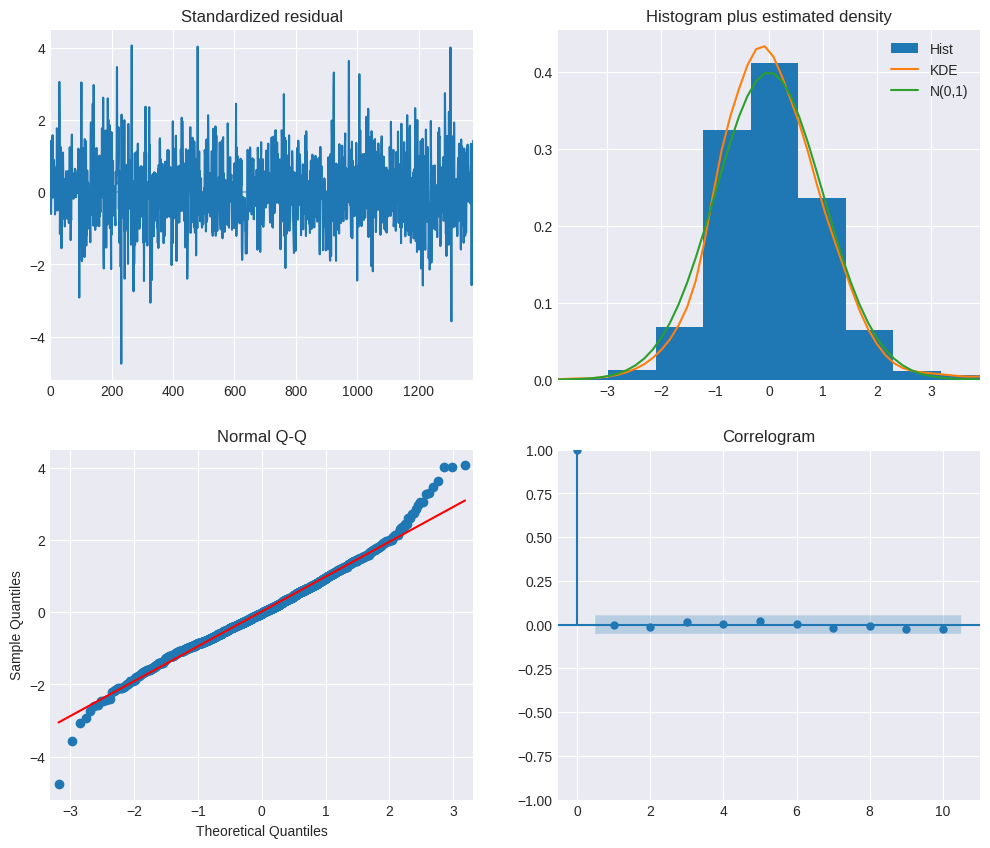

In [ ]:
# Diagnostico grafico los residuos del modelo
fig_res_2 = sarima_model.plot_diagnostics(figsize=(12,10))

In [ ]:
from scipy.stats import shapiro

# Obtener los residuos del modelo ajustado
residuals = sarima_model.resid()

# Aplicar el test de Shapiro-Wilk
shapiro_test = shapiro(residuals)
print('Test de Shapiro-Wilk:')
print(f'Estadístico: {shapiro_test.statistic}, p-valor: {shapiro_test.pvalue}')

Test de Shapiro-Wilk:
Estadístico: 0.987278938293457, p-valor: 1.2641663271750758e-09


In [ ]:
from scipy.stats import boxcox

# Aplicar la transformación de Box-Cox a los datos
df_ventas_deflactadas['Monto_boxcox'], lambda_boxcox = boxcox(df_ventas_deflactadas['Monto_deflactado'])

# Ajuste del modelo ARIMA/SARIMA con los datos transformados
boxcox_model = auto_arima(df_ventas_deflactadas['Monto_boxcox'],
                          seasonal=True, m=6,
                          trace=True, error_action='ignore',
                          suppress_warnings=True)

# Obtener los residuos del modelo ajustado
boxcox_residuals = boxcox_model.resid()

# Aplicar el test de Shapiro-Wilk a los residuos transformados
shapiro_test_boxcox = shapiro(boxcox_residuals)
print(f'Test de Shapiro-Wilk (Transformación de Box-Cox): Estadístico: {shapiro_test_boxcox.statistic}, p-valor: {shapiro_test_boxcox.pvalue}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=7.58 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=30421.110, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=30102.151, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=29667.158, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=30419.113, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=29675.570, Time=0.56 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=29662.527, Time=2.12 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=29666.398, Time=0.52 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=29663.974, Time=5.80 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=29667.186, Time=3.70 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=29665.498, Time=1.48 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=29665.883, Time=1.00 sec
 ARIMA(0,1,1)(2,0,2)[6] intercept   : AIC=inf, Time=10.95 sec
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=30403.948, Time=0.74 sec
 ARIMA(1,1,1)(1,0,1)[6] interc

NameError: name 'shapiro' is not defined

In [ ]:
print(boxcox_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1380
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 6)   Log Likelihood              -14812.659
Date:                             Tue, 09 Jul 2024   AIC                          29635.318
Time:                                     00:27:22   BIC                          29661.463
Sample:                                          0   HQIC                         29645.099
                                            - 1380                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8662      0.026    -33.647      0.000      -0.917      -0.816
ma.L2         -0.0781      

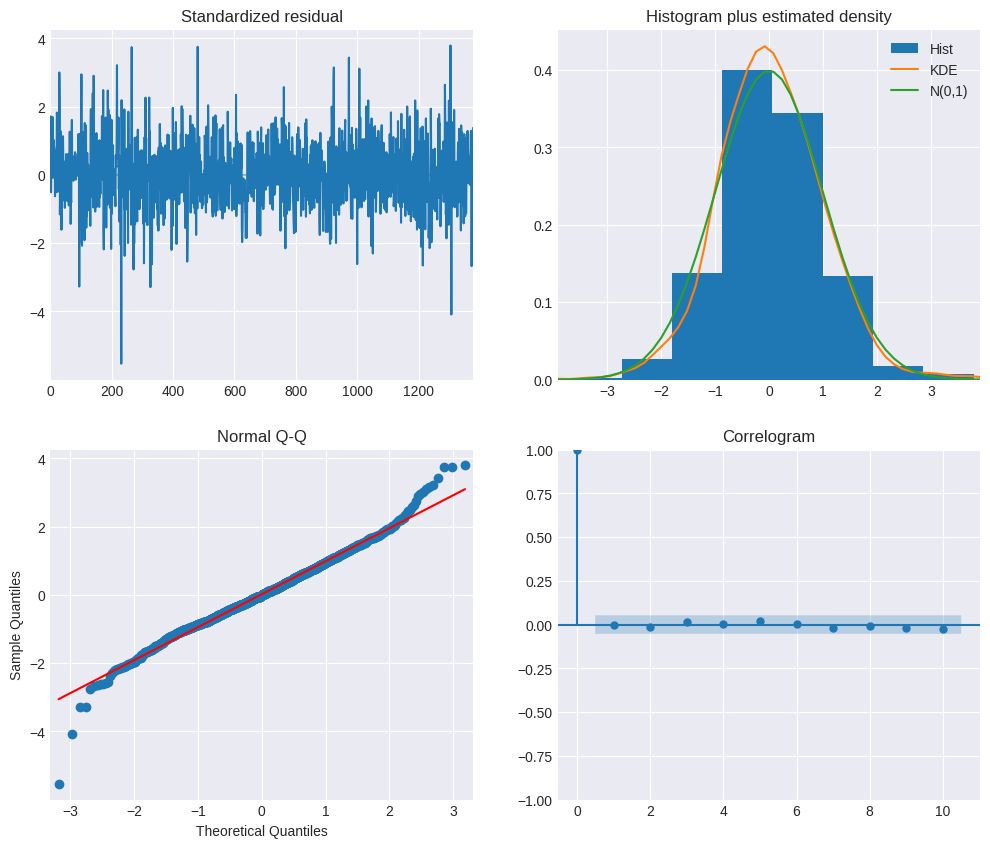

In [ ]:
fig_res_2 = boxcox_model.plot_diagnostics(figsize=(12,10))

A continuacion, vamos a aplicar la transformación logarítmica para ver si con esto logramos resolver el problema de los residuos:

In [ ]:
# Aplicar la transformación logarítmica a los datos
df_ventas_deflactadas['Monto_log'] = np.log(df_ventas_deflactadas['Monto_deflactado'])

# Ajuste del modelo ARIMA/SARIMA con los datos transformados
log_model = auto_arima(df_ventas_deflactadas['Monto_log'],
                       seasonal=True, m=6,
                       trace=True, error_action='ignore',
                       suppress_warnings=True)

# Obtener los residuos del modelo ajustado
log_residuals = log_model.resid()

# Aplicar el test de Shapiro-Wilk a los residuos transformados
shapiro_test_log = shapiro(log_residuals)
print(f'Test de Shapiro-Wilk (Transformación Logarítmica): Estadístico: {shapiro_test_log.statistic}, p-valor: {shapiro_test_log.pvalue}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=134.092, Time=14.44 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=937.405, Time=0.44 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=601.442, Time=2.10 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=133.390, Time=3.95 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=935.406, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=143.611, Time=1.27 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=132.757, Time=4.42 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=132.344, Time=2.57 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=132.576, Time=6.56 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=134.600, Time=4.18 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=922.146, Time=0.31 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=129.065, Time=1.53 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=141.980, Time=1.06 sec
 ARIMA(1,1,1)(2,0,0)[6] intercept   : AIC=129.308, Time=10.04 sec
 ARIMA(1,1,1)(1,0,1)[6] intercept   : AIC=129

In [ ]:
print(log_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1380
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 6)   Log Likelihood                 -59.566
Date:                            Sat, 06 Jul 2024   AIC                            127.133
Time:                                    01:02:24   BIC                            148.049
Sample:                                         0   HQIC                           134.957
                                           - 1380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8818      0.019    -45.637      0.000      -0.920      -0.844
ma.L2         -0.0637      0.020   

Dados estos resultados, me quedo con el modelo original.

6) Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

# Ordenar el DataFrame por fecha
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)

# Separar el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(df_sorted) * 0.8)
train, test = df_sorted.iloc[:train_size], df_sorted.iloc[train_size:]

# Aplicar la transformación de Box-Cox
train['Monto_boxcox'], lam = boxcox(train['Monto_deflactado'])

# Ajuste del modelo SARIMA en el conjunto de entrenamiento con la transformación Box-Cox
boxcox_model_with_train = auto_arima(train['Monto_boxcox'],
                          seasonal=True, m=6,
                          trace=True, error_action='ignore',
                          suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=23847.643, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=23571.194, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=23241.565, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=23845.644, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=23244.748, Time=0.46 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=23242.954, Time=1.62 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=23243.921, Time=1.26 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=23241.321, Time=0.99 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=23242.861, Time=2.08 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=23836.773, Time=0.23 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=23240.882, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=23243.620, Time=1.33 sec
 ARIMA(1,1,1)(2,0,0)[6] interce

In [ ]:
print (boxcox_model_with_train.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1104
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 6)   Log Likelihood              -11609.690
Date:                            Tue, 09 Jul 2024   AIC                          23227.380
Time:                                    00:30:20   BIC                          23247.403
Sample:                                         0   HQIC                         23234.954
                                           - 1104                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8654      0.028    -31.057      0.000      -0.920      -0.811
ma.L2         -0.0676      0.028   

RMSE: 184831.99366949606
MAE: 148744.7578588308


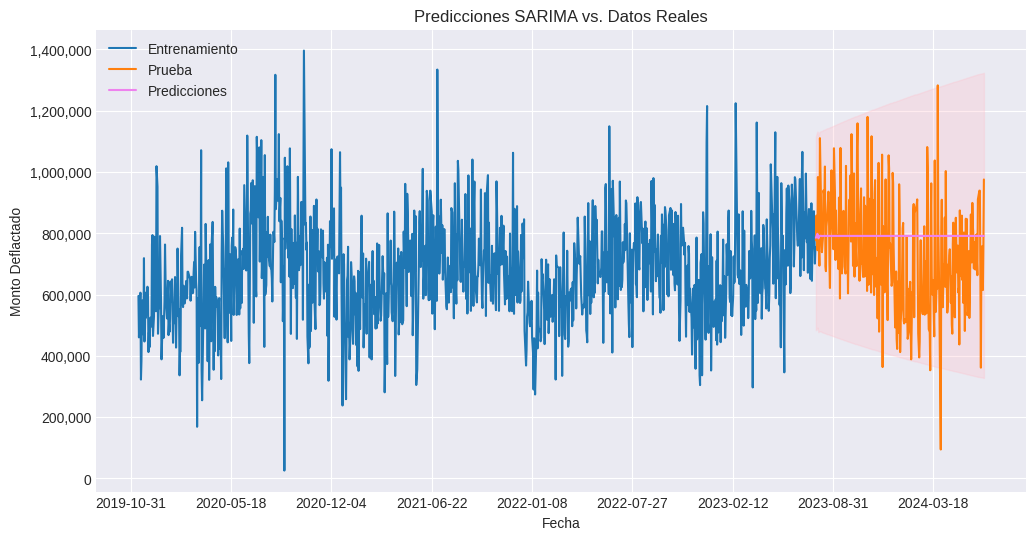

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Realizar la predicción en el conjunto de prueba con intervalo de confianza
predictions_boxcox, conf_int = boxcox_model_with_train.predict(n_periods=len(test), return_conf_int=True)
predictions_boxcox_inverse = inv_boxcox(predictions_boxcox, lam)  # Invertir la transformación
conf_int_inverse = inv_boxcox(conf_int, lam)

# Calcular las métricas de performance
rmse = np.sqrt(mean_squared_error(test['Monto_deflactado'], predictions_boxcox_inverse))
mae = mean_absolute_error(test['Monto_deflactado'], predictions_boxcox_inverse)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train['Fecha'], train['Monto_deflactado'], label='Entrenamiento')
plt.plot(test['Fecha'], test['Monto_deflactado'], label='Prueba')
plt.plot(test['Fecha'], predictions_boxcox_inverse, label='Predicciones', color='violet')
plt.fill_between(test['Fecha'],
                 conf_int_inverse[:, 0],
                 conf_int_inverse[:, 1], color='pink', alpha=0.3)

# Formatear los ejes para evitar notación científica
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones SARIMA vs. Datos Reales')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=8.83 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=23847.643, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=23571.194, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=23241.565, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=23845.644, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=23244.748, Time=0.89 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=23242.954, Time=2.72 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=23243.921, Time=2.55 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=23241.321, Time=0.95 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=23242.861, Time=1.85 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=inf, Time=4.31 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=23836.773, Time=0.35 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=23240.882, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=23243.620, Time=0.72 sec
 ARIMA(1,1,1)(2,0,0)[6] interce

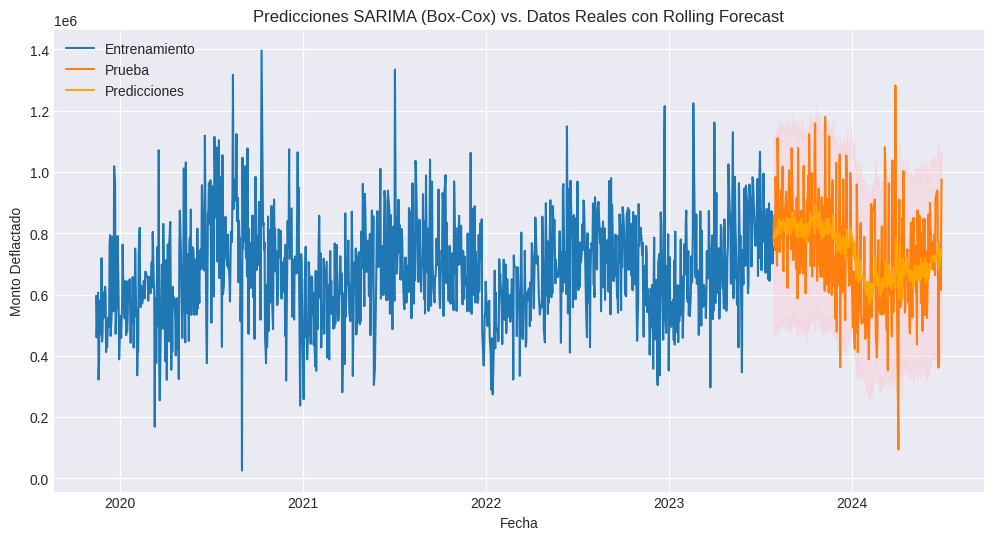

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox
from scipy.stats import boxcox

# Ordenar el DataFrame por fecha
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)

# Separar el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(df_sorted) * 0.8)
train, test = df_sorted.iloc[:train_size], df_sorted.iloc[train_size:]

# Aplicar la transformación de Box-Cox a los datos de entrenamiento
train_boxcox, lam = boxcox(train['Monto_deflactado'])

# Ajuste del modelo SARIMA en el conjunto de entrenamiento transformado
boxcox_rolling_forecast_model = auto_arima(train_boxcox,
                                           seasonal=True, m=6,
                                           trace=True, error_action='ignore',
                                           suppress_warnings=True)


RMSE: 165262.72458288845
MAE: 129582.23488206035


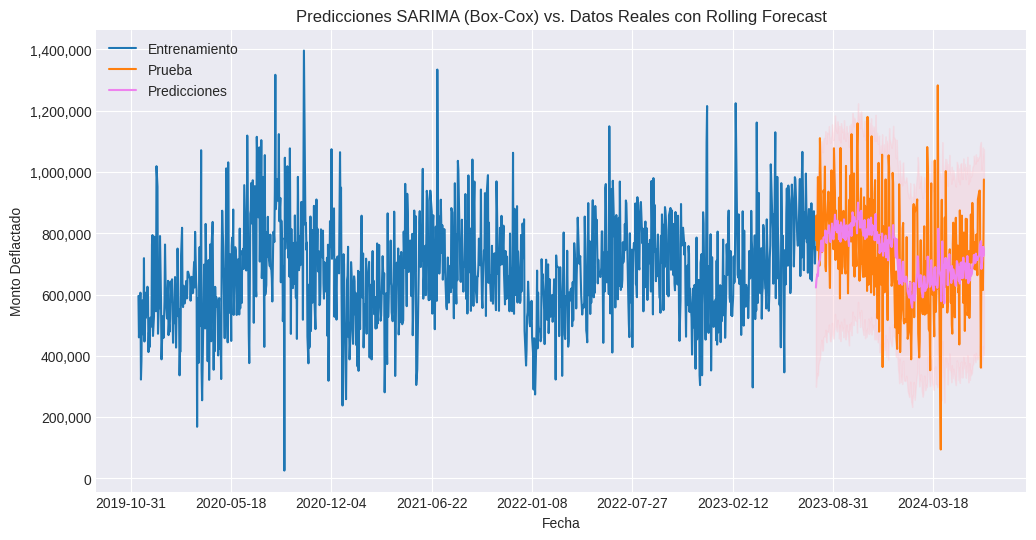

In [ ]:
# Predicciones con rolling forecast
predictions_boxcox = []
history = list(train_boxcox)
for t in range(len(test)):
    model = boxcox_rolling_forecast_model.fit(history)
    yhat = model.predict(n_periods=1)
    predictions_boxcox.append(yhat[0])
    # Actualizar el historial con el valor real transformado (Box-Cox)
    actual_transformed = boxcox([test['Monto_deflactado'].iloc[t]], lam)
    history.append(actual_transformed[0])

# Invertir la transformación de Box-Cox en las predicciones
predictions = inv_boxcox(predictions_boxcox, lam)

# Calcular las métricas de performance
rmse = np.sqrt(mean_squared_error(test['Monto_deflactado'], predictions))
mae = mean_absolute_error(test['Monto_deflactado'], predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train['Fecha'], train['Monto_deflactado'], label='Entrenamiento')
plt.plot(test['Fecha'], test['Monto_deflactado'], label='Prueba')
plt.plot(test['Fecha'], predictions, label='Predicciones', color='violet')
plt.fill_between(test['Fecha'], predictions - 1.96 * rmse, predictions + 1.96 * rmse, color='pink', alpha=0.3)

# Formatear los ejes para evitar notación científica
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones SARIMA (Box-Cox) vs. Datos Reales con Rolling Forecast')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=9.61 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=30421.076, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=30102.116, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=29667.123, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=30419.078, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=29675.536, Time=1.38 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=29662.492, Time=1.95 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=29666.364, Time=0.52 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=29663.939, Time=6.39 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=29667.151, Time=2.22 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=29665.464, Time=1.27 sec
 ARIMA(0,1,1)(2,0,0)[6] intercept   : AIC=29665.849, Time=0.92 sec
 ARIMA(0,1,1)(2,0,2)[6] intercept   : AIC=inf, Time=6.77 sec
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=30403.914, Time=1.17 sec
 ARIMA(1,1,1)(1,0,1)[6] interce

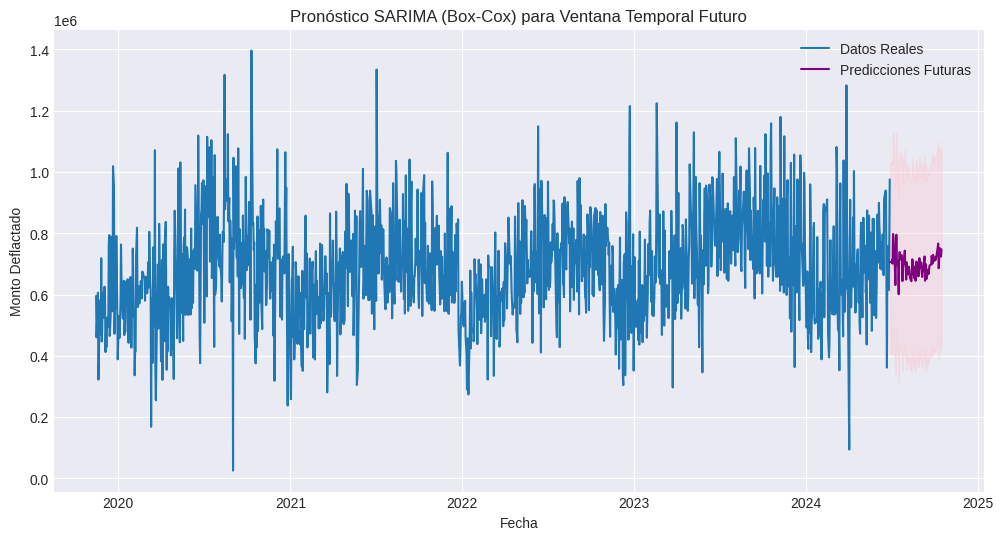

In [ ]:
######  Predicciones futuras
from scipy.stats import boxcox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Transformar los datos utilizando Box-Cox y determinar el mejor valor para lambda
df_sorted = df_ventas_deflactadas.sort_values('Fecha', ascending=True)

# Asegúrate de que no hay valores negativos o cero en 'Monto_deflactado'
df_sorted['Monto_deflactado'] = df_sorted['Monto_deflactado'].replace(0, np.nan)  # Opcional: reemplazar ceros con NaN para evitarlos
df_sorted['Monto_deflactado'] = df_sorted['Monto_deflactado'].dropna()  # Eliminar NaNs

# Aplicar Box-Cox transformando los valores a positivos
df_sorted['Monto_deflactado_boxcox'], lam = boxcox(df_sorted['Monto_deflactado'] + 1)  # Añadir 1 para evitar problemas con valores cero o negativos

# Definir la función para el pronóstico con Rolling Forecast usando Box-Cox
def rolling_forecast_boxcox(model, train, lam, steps=78):
    history = list(train['Monto_deflactado_boxcox'])
    predictions = []
    conf_ints = []

    for t in range(steps):
        model_fit = model.fit(history)
        yhat, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)
        predictions.append(yhat[0])
        conf_ints.append(conf_int[0])
        actual_transformed = boxcox([train['Monto_deflactado'].iloc[-steps + t] + 1], lmbda=lam)[0]  # Transformar y agregar al historial
        history.append(actual_transformed)

    return predictions, conf_ints

# Ajuste automático del modelo SARIMA con transformación Box-Cox
boxcox_rolling_forecast_model = auto_arima(df_sorted['Monto_deflactado_boxcox'],
                                           seasonal=True, m=6,
                                           trace=True, error_action='ignore',
                                           suppress_warnings=True)

# Realizar el pronóstico para los próximos 78 días
future_predictions_boxcox, conf_ints_boxcox = rolling_forecast_boxcox(boxcox_rolling_forecast_model, df_sorted, lam, steps=78)
future_predictions_boxcox_inverse = inv_boxcox(np.array(future_predictions_boxcox), lam) - 1  # Invertir la transformación

# Crear un rango de fechas para las predicciones futuras
last_date = df_sorted['Fecha'].max()
future_dates = pd.date_range(start=last_date, periods=79, freq='B')[1:]  # Saltar el primer día para empezar después del último dato conocido

# Crear DataFrame para las predicciones futuras
future_df_boxcox = pd.DataFrame({'Fecha': future_dates, 'Predicciones': future_predictions_boxcox_inverse})

# Invertir la transformación de Box-Cox en los intervalos de confianza
conf_ints_boxcox_inverse = inv_boxcox(np.array(conf_ints_boxcox).flatten(), lam) - 1
conf_ints_boxcox_inverse = conf_ints_boxcox_inverse.reshape(-1, 2)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['Fecha'], df_sorted['Monto_deflactado'], label='Datos Reales')
plt.plot(future_df_boxcox['Fecha'], future_df_boxcox['Predicciones'], label='Predicciones Futuras', color='purple')
plt.fill_between(future_df_boxcox['Fecha'], conf_ints_boxcox_inverse[:, 0], conf_ints_boxcox_inverse[:, 1], color='pink', alpha=0.3)
plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Pronóstico SARIMA (Box-Cox) para Ventana Temporal Futuro')
plt.legend()
plt.show()